In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab import drive

# Load the Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Load Data Function
def load_data(file_path):
    """Load data from an Excel file and display the first 10 rows."""
    try:
        data = pd.read_excel(file_path, sheet_name=None, engine='openpyxl')  # Load all sheets
        print("Data loaded successfully.")
        for sheet_name, sheet_data in data.items():
            print(f"First 10 rows of '{sheet_name}':")
            display(sheet_data.head(10))
        return data
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Call load_data
file_path = '/content/drive/MyDrive/KSU/RCapstone/feature-prediction/data/all_data.xlsx'
data = load_data(file_path)

Data loaded successfully.
First 10 rows of 'good':


,Name,Timestamp,Status,Description,Vibration Frequency,Vibration Amplitude,Bearing Temperature,Motor Temperature,Belt Load,Torque,Noise Levels,Current and Voltage,Hydraulic Pressure,Belt Thickness,Roller Condition
0,Conveyor Belt 4,2023-08-15 00:00:00,Running,NaN,1490.82,0.04,NaN,96.902,1.36,318.07,55.12,15.79,382.09,1.58,86
1,Conveyor Belt 4,2023-08-15 00:15:00,Running,NaN,1498.37,0.04,77.076,96.975,1.07,295.5,59.68,14.34,376.48,1.5795,85.854
2,Conveyor Belt 4,2023-08-15 00:30:00,Running,NaN,1503.22,0.06,77.307,96.755,1.21,314.38,58.2,15.03,384.2,1.57925,85.781
3,Conveyor Belt 4,2023-08-15 00:45:00,Running,NaN,1508.11,0.04,77.474,97.661,1.29,311.84,56.16,15.43,379.79,1.579,85.708
4,Conveyor Belt 4,2023-08-15 01:00:00,Running,NaN,1498.13,0.06,77.785,97.471,1.07,317.14,55.39,14.35,383.95,1.57875,85.635
5,Conveyor Belt 4,2023-08-15 01:15:00,Running,NaN,1494.89,0.05,77.813,97.814,1.33,305.58,NaN,15.65,383.02,1.5785,85.562
6,Conveyor Belt 4,2023-08-15 01:30:00,Running,NaN,1498.2,0.06,77.622,97.464,1.18,285.96,59.25,14.91,383.54,1.57825,85.489
7,Conveyor Belt 4,2023-08-15 01:45:00,Running,NaN,1507.17,0.06,78.487,98.139,1.24,298.84,58.93,15.21,377.37,1.578,85.416
8,Conveyor Belt 4,2023-08-15 02:00:00,Running,NaN,1507.43,0.06,78.294,97.877,1.07,307.51,61.77,14.36,377.28,1.57775,85.343
9,Conveyor Belt 4,2023-08-15 02:15:00,Running,NaN,1502.35,0.05,78.561,98.96,1.17,308.73,62.23,14.87,377.47,1.5775,85.27


First 10 rows of 'bad':


,Name,Timestamp,Status,Description,Vibration Frequency,Vibration Amplitude,Bearing Temperature,Motor Temperature,Belt Load,Torque,Noise Levels,Current and Voltage,Hydraulic Pressure,Belt Thickness,Roller Condition
0,Conveyor Belt 4,2023-08-15 00:00:00,Running,NaN,1490.82,0.04,77.13,96.902,1.36,318.07,55.12,15.79,382.09,1.58000,86.000
1,Conveyor Belt 4,2023-08-15 00:15:00,Running,NaN,1498.37,0.04,77.076,ERROR,1.07,295.5,59.68,14.34,376.48,NaN,85.854
2,Conveyor Belt 4,2023-08-15 00:30:00,Running,NaN,1503.22,0.06,77.307,96.755,1.21,314.38,58.20,15.03,384.2,1.57925,85.781
3,Conveyor Belt 4,2023-08-15 00:45:00,Running,NaN,NaN,0.04,77.474,97.661,NaN,311.84,56.16,15.43,379.79,1.57900,85.708
4,Conveyor Belt 4,2023-08-15 01:00:00,Running,NaN,1498.13,0.06,77.785,97.471,1.07,317.14,55.39,14.35,383.95,1.57875,85.635
5,Conveyor Belt 4,2023-08-15 01:15:00,Running,NaN,1494.89,0.05,77.813,97.814,1.33,305.58,62.25,15.65,383.02,1.57850,85.562
6,Conveyor Belt 4,2023-08-15 01:30:00,NaN,NaN,1498.2,ERROR,77.622,97.464,1.18,285.96,59.25,14.91,383.54,1.57825,85.489
7,Conveyor Belt 4,2023-08-15 01:45:00,Running,NaN,1507.17,0.06,78.487,98.139,1.24,298.84,58.93,15.21,377.37,1.57800,85.416
8,Conveyor Belt 4,2023-08-15 02:00:00,Running,NaN,1507.43,0.06,78.294,97.877,1.07,307.51,61.77,14.36,NaN,1.57775,85.343
9,Conveyor Belt 4,2023-08-15 02:15:00,Running,NaN,1502.35,0.05,78.561,98.96,1.17,308.73,62.23,14.87,377.47,1.57750,85.270


In [65]:
def clean_and_preprocess_data(data):
    """Clean the data by removing NaN values and creating lagged features for all relevant columns."""
    cleaned_data = {}

    for sheet_name, sheet_data in data.items():
        if not isinstance(sheet_data, pd.DataFrame):
            print(f"Expected DataFrame but got: {type(sheet_data)}. Skipping...")
            continue

        # Check if the necessary columns are present
        if 'Timestamp' not in sheet_data.columns:
            print(f"'Timestamp' column is missing in the sheet: {sheet_name}. Skipping...")
            continue

        # Normalize Timestamp format and handle errors
        sheet_data['Timestamp'] = pd.to_datetime(sheet_data['Timestamp'], errors='coerce')

        # Drop rows with NaT values in Timestamp
        sheet_data.dropna(subset=['Timestamp'], inplace=True)

        # Convert all columns to numeric, dropping non-numeric columns
        sheet_data = sheet_data.apply(pd.to_numeric, errors='coerce')
        sheet_data.fillna(0, inplace=True)

        # Create lagged features for all numeric columns (excluding 'Timestamp')
        numeric_columns = sheet_data.select_dtypes(include=[np.number]).columns.tolist()
        for lag in range(1, 5):  # Create 4 lagged features for each numeric column
            for col in numeric_columns:
                if col != 'Timestamp':  # Exclude the timestamp from lagging
                    sheet_data[f'{col} lag {lag}'] = sheet_data[col].shift(lag)

        # Drop rows with NaN values created by shifting
        sheet_data.dropna(inplace=True)

        # Ensure the cleaned_data entry is still a DataFrame with at least one numeric column
        if sheet_data.shape[1] > 1 and not sheet_data.empty:  # More than one column and not empty
            cleaned_data[sheet_name] = sheet_data
        else:
            print(f"No valid data remaining in the sheet: {sheet_name}. Skipping...")

    return cleaned_data


for sheet_name, sheet_data in cleaned_data.items():
    print(f"Processed '{sheet_name}' with shape: {sheet_data.shape}")
    print(sheet_data.head())  # Display the first few rows


Processed 'Name' with shape: (2583,)
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
Name: Name, dtype: float64
Processed 'Timestamp' with shape: (2583,)
4    1692061200000000000
5    1692062100000000000
6    1692063000000000000
7    1692063900000000000
8    1692064800000000000
Name: Timestamp, dtype: int64
Processed 'Status' with shape: (2583,)
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
Name: Status, dtype: float64
Processed 'Description' with shape: (2583,)
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
Name: Description, dtype: float64
Processed 'Vibration Frequency' with shape: (2583,)
4    1498.13
5    1494.89
6    1498.20
7    1507.17
8    1507.43
Name: Vibration Frequency, dtype: float64
Processed 'Vibration Amplitude' with shape: (2583,)
4    0.06
5    0.05
6    0.06
7    0.06
8    0.06
Name: Vibration Amplitude, dtype: float64
Processed 'Bearing Temperature' with shape: (2583,)
4    77.785
5    77.813
6    77.622
7    78.487
8    78.294
Name: Bearing Temperature, dtype: float64
P

In [61]:
# 3. Combine Data Function
def combine_data(cleaned_data):
    """Combine good and bad data into a single DataFrame."""
    combined_data = pd.concat(cleaned_data.values(), ignore_index=True)
    combined_data['Data Type'] = np.where(combined_data['Vibration Frequency'] > 1500, 'Bad', 'Good')  # Example classification
    return combined_data


In [62]:
# 4. Build Model Function
def build_model(input_shape):
    """Build a simple neural network model."""
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2199152.7500 - val_loss: 2054178.5000
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1908411.0000 - val_loss: 1222037.1250
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 922760.1875 - val_loss: 144652.3906
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 81093.8281 - val_loss: 28575.9922
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26145.7910 - val_loss: 27969.4375
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33007.1992 - val_loss: 28146.9570
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24896.7559 - val_loss: 27818.3145
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31669.8828 - val_loss: 28026.7246
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25478.3867 - val_loss: 27876.2070
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26019.1367 - val_loss: 27914.6719
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

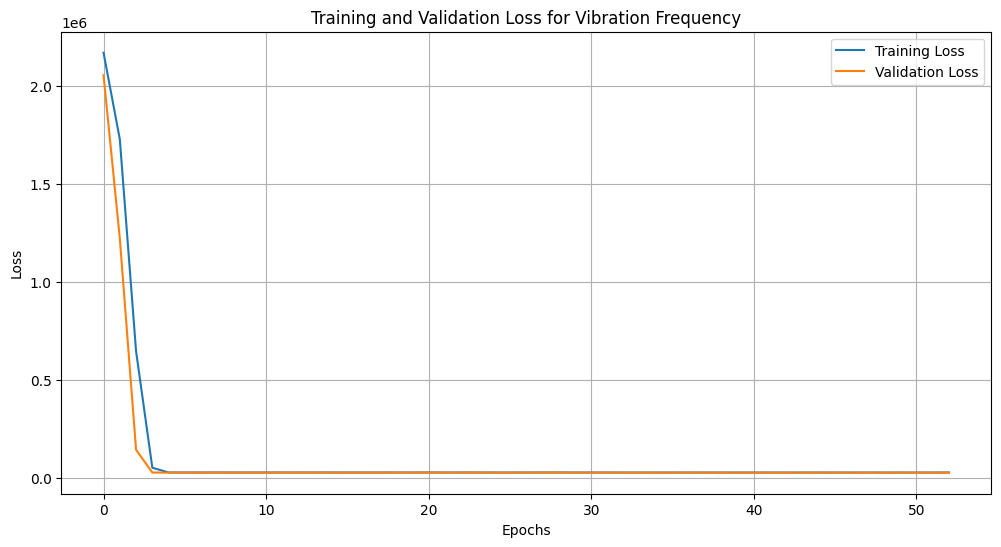

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0117 - val_loss: 0.0014
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7742e-04 - val_loss: 6.9936e-04
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9939e-04 - val_loss: 5.1602e-04
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6408e-04 - val_loss: 4.6078e-04
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6794e-04 - val_loss: 3.8356e-04
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5201e-04 - val_loss: 3.0609e-04
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8749e-04 - val_loss: 3.8362e-04
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8819e-04 - val_loss: 2.5979e-04
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6541e-04 - val_loss: 2.3114e-04
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4181e-04 - val_loss: 2.3335e-04
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7197e-04 - val_

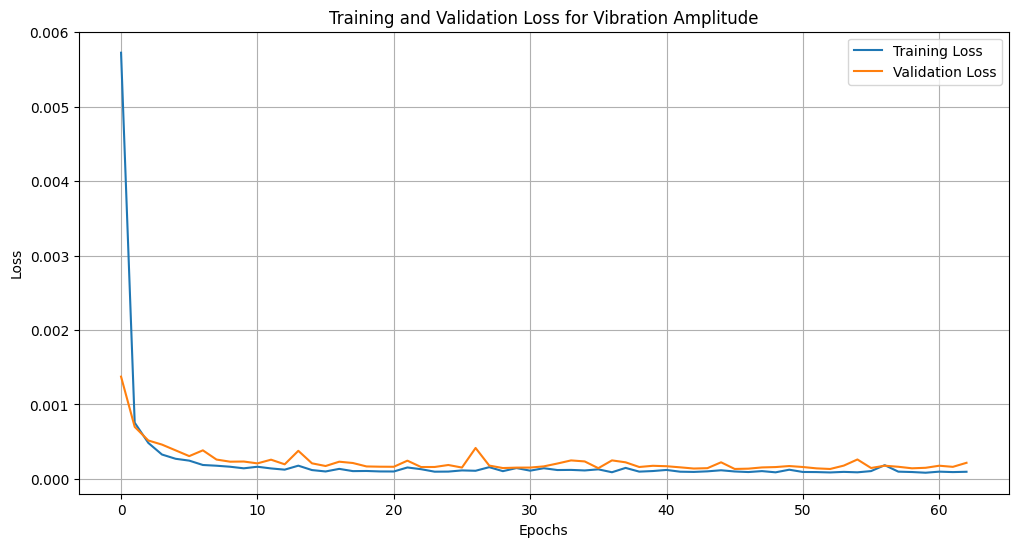

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3820.6738 - val_loss: 91.0380
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101.5290 - val_loss: 27.7645
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77.9300 - val_loss: 27.7287
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 87.2166 - val_loss: 27.3801
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 97.9765 - val_loss: 27.0960
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 88.5004 - val_loss: 28.5785
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78.9072 - val_loss: 28.0649
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95.5079 - val_loss: 27.3157
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85.3139 - val_loss: 25.9499
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.0661 - val_loss: 25.8564
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113.5586 - val_loss: 25.3944
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━

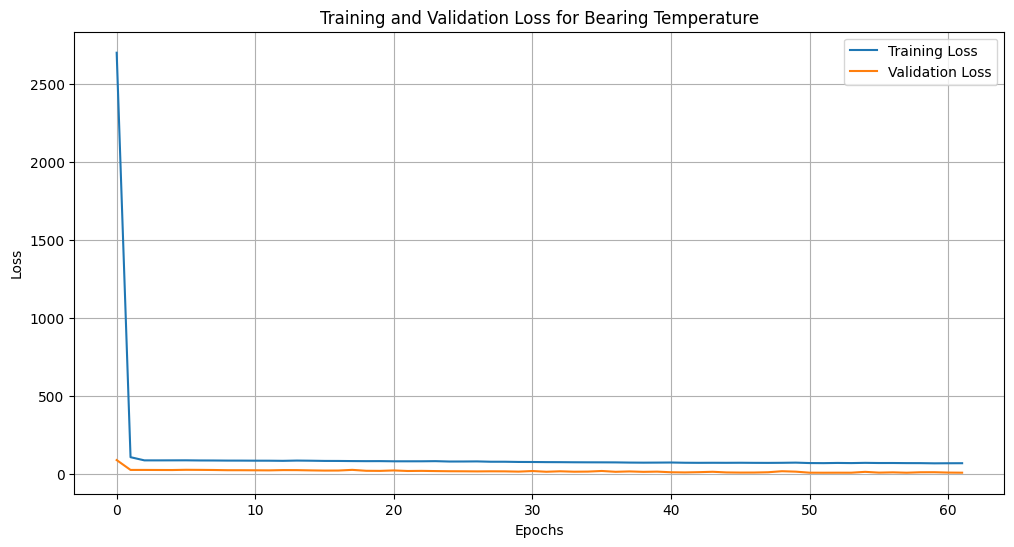

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6473.8833 - val_loss: 523.0752
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 183.4951 - val_loss: 118.6984
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92.1253 - val_loss: 122.5910
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.8465 - val_loss: 118.7573
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 90.8379 - val_loss: 117.8492
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.1963 - val_loss: 120.0733
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96.4102 - val_loss: 121.0155
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.6654 - val_loss: 120.3939
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78.7236 - val_loss: 119.3730
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64.2489 - val_loss: 117.5625
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.7456 - val_loss: 116.9878
Epoch 12/100
52/52 ━━━━━━━

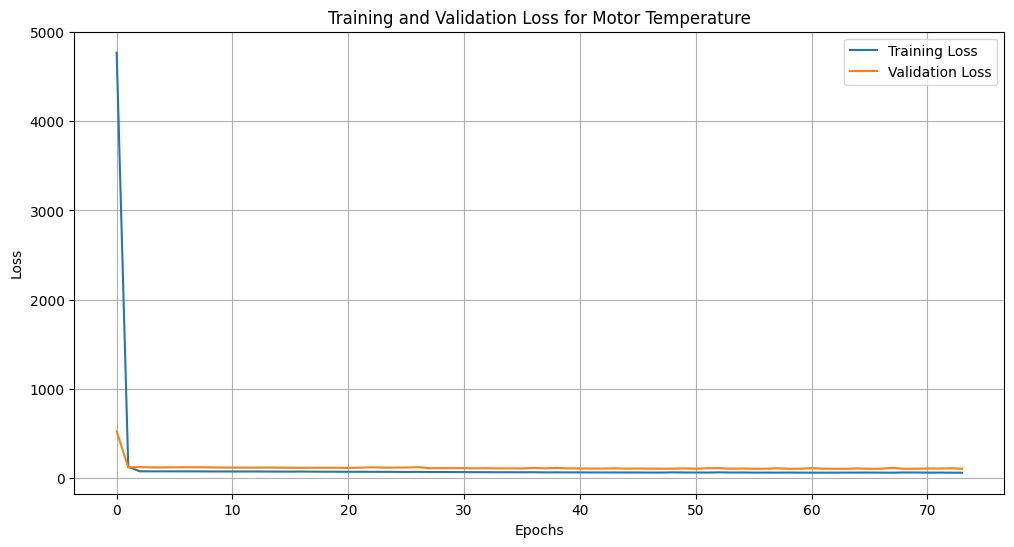

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4458 - val_loss: 0.0376
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 - val_loss: 0.0342
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - val_loss: 0.0350
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.0334
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0276 - val_loss: 0.0338
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 - val_loss: 0.0388
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 - val_loss: 0.0354
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.0339
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.0328
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244 - val_loss: 0.0323
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - val_loss: 0.0323
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

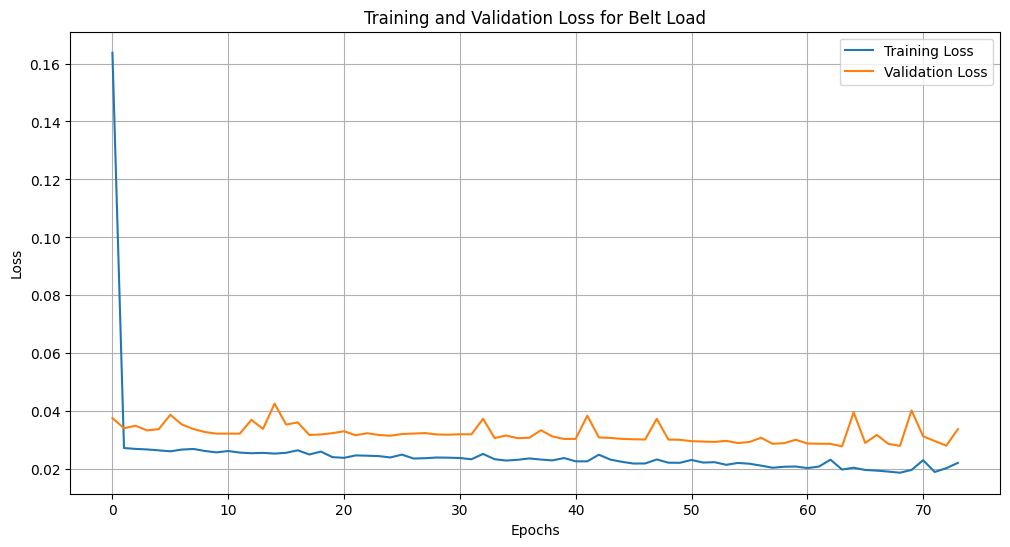

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 83626.1719 - val_loss: 52327.3320
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33988.8047 - val_loss: 2098.6250
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1062.6162 - val_loss: 1905.7494
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1470.5352 - val_loss: 1967.8225
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 963.1642 - val_loss: 1925.9209
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1214.3541 - val_loss: 1940.6959
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1297.8861 - val_loss: 1907.0319
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1162.6145 - val_loss: 1926.4998
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1154.2983 - val_loss: 1903.2545
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1160.2245 - val_loss: 1920.4108
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 932.4169 - val_loss: 1911.0

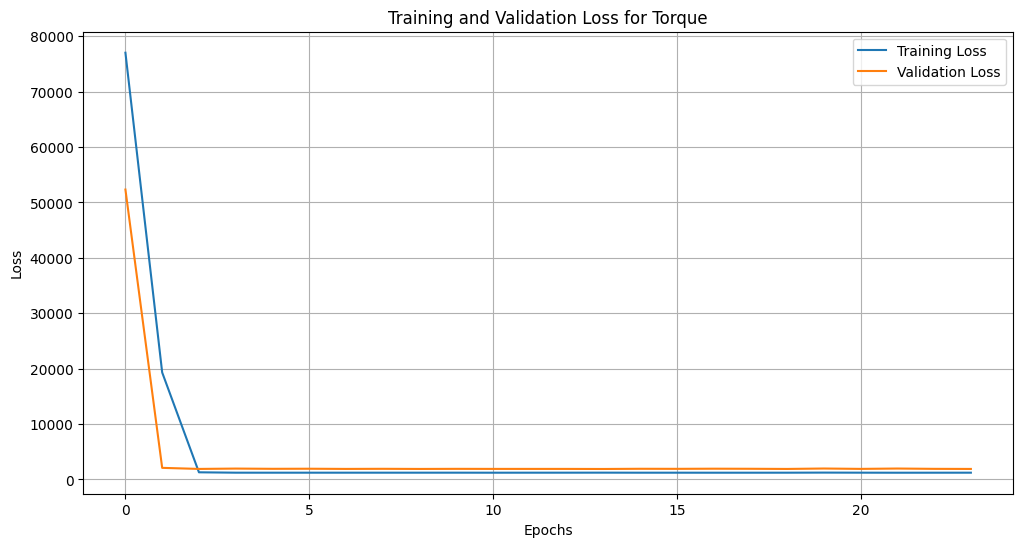

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2554.2673 - val_loss: 139.0856
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.3324 - val_loss: 87.3065
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.9193 - val_loss: 85.8770
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.5428 - val_loss: 86.0860
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.8632 - val_loss: 85.8015
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.5149 - val_loss: 86.6075
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.1526 - val_loss: 85.7830
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.5662 - val_loss: 85.7148
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.7766 - val_loss: 85.6386
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.6002 - val_loss: 85.7683
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 36.6619 - val_loss: 86.9704
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━

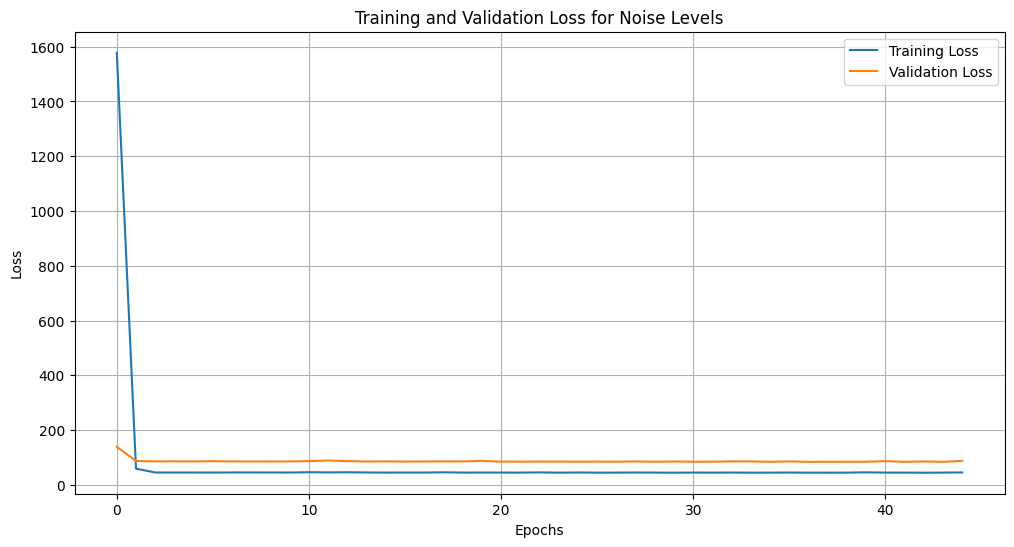

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 125.0456 - val_loss: 2.1177
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8293 - val_loss: 2.1604
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6974 - val_loss: 2.1022
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3028 - val_loss: 2.1549
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3326 - val_loss: 2.1510
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2014 - val_loss: 2.1145
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9502 - val_loss: 2.1477
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5735 - val_loss: 2.0862
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2783 - val_loss: 2.0819
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7922 - val_loss: 2.1110
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7566 - val_loss: 2.0726
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

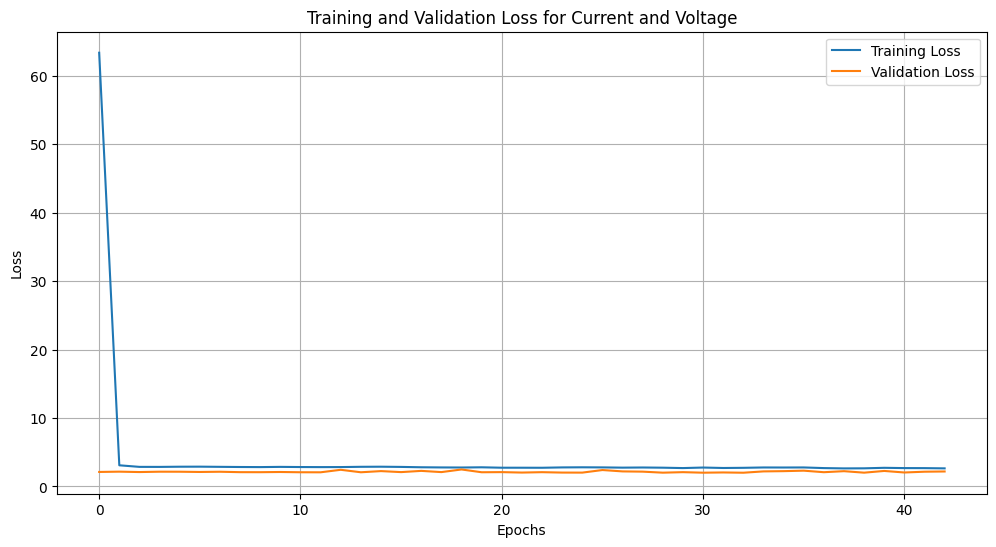

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 138995.5469 - val_loss: 96355.9844
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66727.9141 - val_loss: 1808.7825
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 583.3375 - val_loss: 1829.5248
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 197.1886 - val_loss: 1853.3586
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 826.5602 - val_loss: 1891.3031
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 984.8834 - val_loss: 1927.8381
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 763.9999 - val_loss: 1902.5432
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 595.9184 - val_loss: 1866.3783
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 536.8772 - val_loss: 1890.0024
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 345.1461 - val_loss: 1884.0107
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 347.4249 - val_loss: 1866.8834
Ep

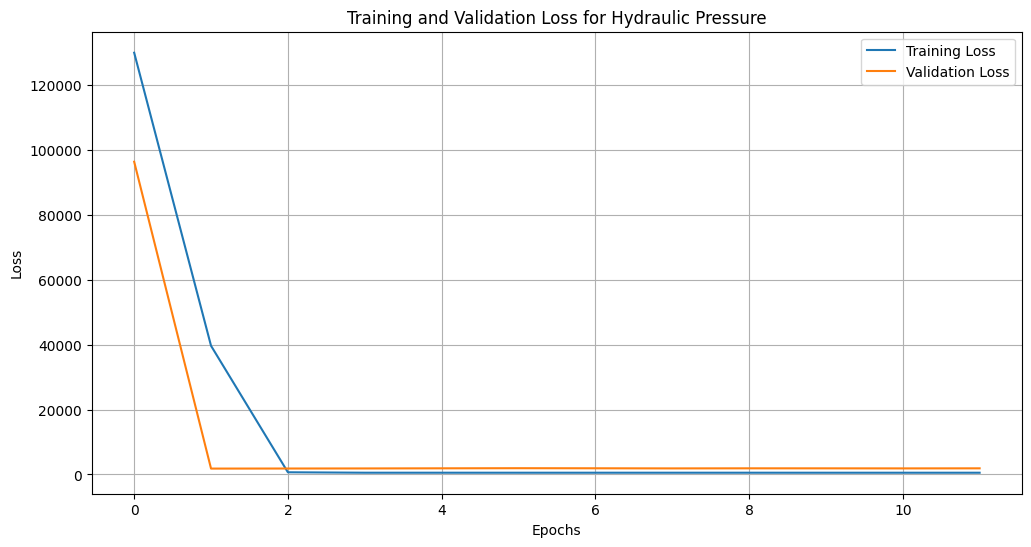

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5268 - val_loss: 0.0404
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.0393
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.0405
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358 - val_loss: 0.0393
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0387 - val_loss: 0.0377
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0409 - val_loss: 0.0381
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - val_loss: 0.0378
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0347 - val_loss: 0.0384
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348 - val_loss: 0.0376
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0337 - val_loss: 0.0371
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0381 - val_loss: 0.0393
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

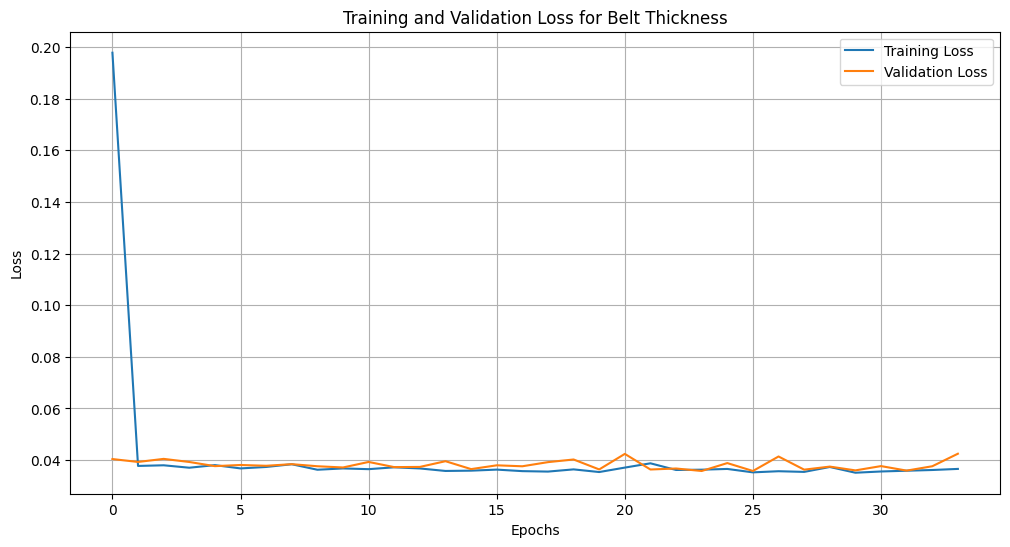

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5848.6318 - val_loss: 749.6394
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 303.2968 - val_loss: 163.6933
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 132.3517 - val_loss: 159.1628
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 198.5885 - val_loss: 150.9926
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 165.6021 - val_loss: 150.6735
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 171.9194 - val_loss: 149.0254
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140.5955 - val_loss: 148.9558
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 148.3069 - val_loss: 145.8402
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 163.1369 - val_loss: 149.6263
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 135.1840 - val_loss: 147.0891
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 125.6415 - val_loss: 144.0943
Epoch 12/100
52/52

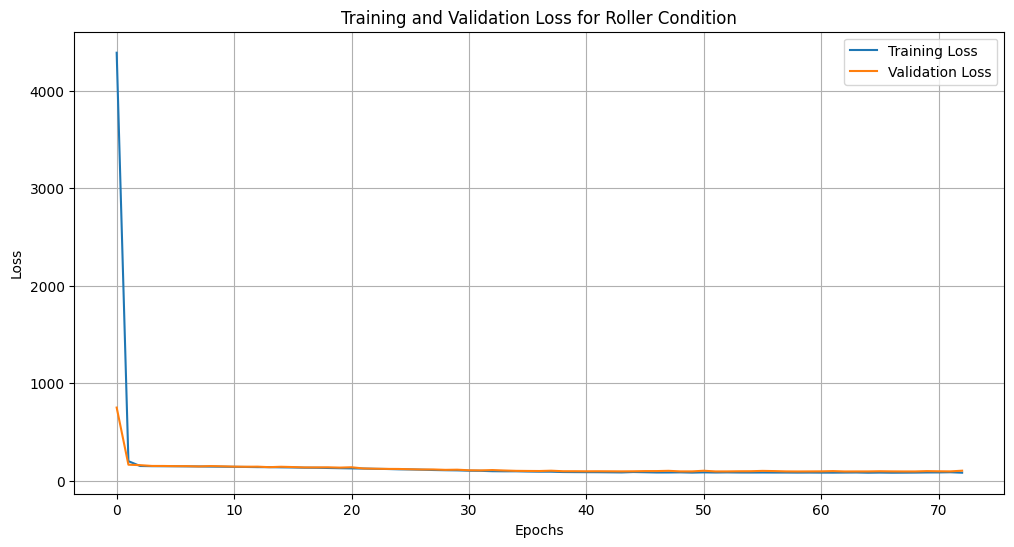

In [53]:
# 5. Train Models Function
def train_models(combined_data):
    """Train models on the numeric columns of cleaned data."""
    models = {}
    scalers = {}
    target_columns = [
        'Vibration Frequency',
        'Vibration Amplitude',
        'Bearing Temperature',
        'Motor Temperature',
        'Belt Load',
        'Torque',
        'Noise Levels',
        'Current and Voltage',
        'Hydraulic Pressure',
        'Belt Thickness',
        'Roller Condition'
    ]

    for target_column in target_columns:
        if target_column not in combined_data.columns:
            continue  # Skip if target column doesn't exist

        # Prepare features and target variable
        X = combined_data.drop(columns=[target_column])
        y = combined_data[target_column]

        # Scale features
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # Train-test split
        split_index = int(len(X_scaled) * 0.8)
        X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        model = build_model(X_train.shape[1])  # Build the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model
        history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                            validation_split=0.2, callbacks=[early_stopping], verbose=1)

        # Save the model and scaler
        model_dir = '/content/models'
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model.save(f'{model_dir}/{target_column}_model.keras')
        joblib.dump(scaler, f'{model_dir}/{target_column}_scaler.pkl')

        # Store model and scaler
        models[target_column] = model
        scalers[target_column] = scaler

        # Plot training history
        plot_training_history(history, target_column)  # Plotting the training history

    return models, scalers

# Call train_models
models, scalers = train_models(cleaned_data)


Plotting training history for Vibration Frequency...


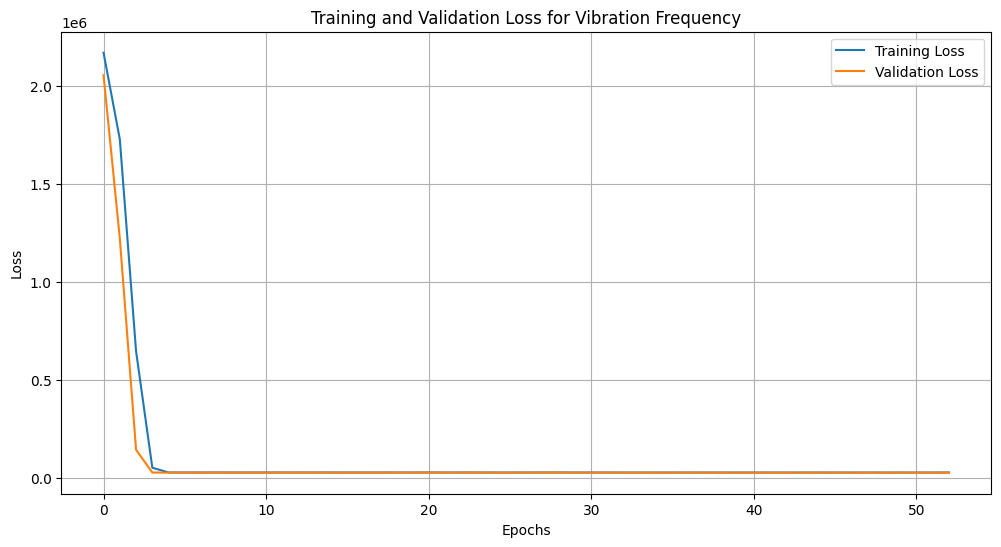

Plotting training history for Vibration Amplitude...


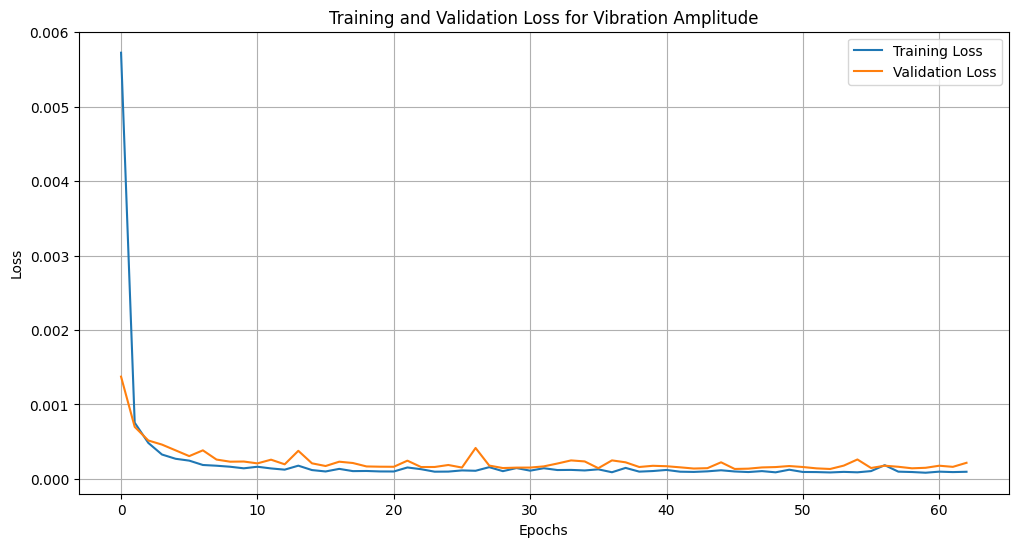

Plotting training history for Bearing Temperature...


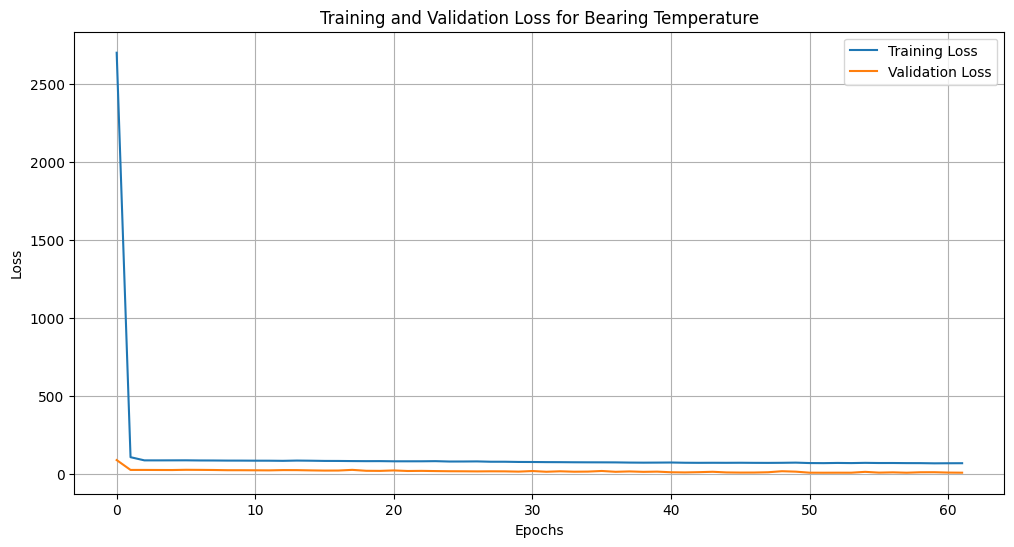

Plotting training history for Motor Temperature...


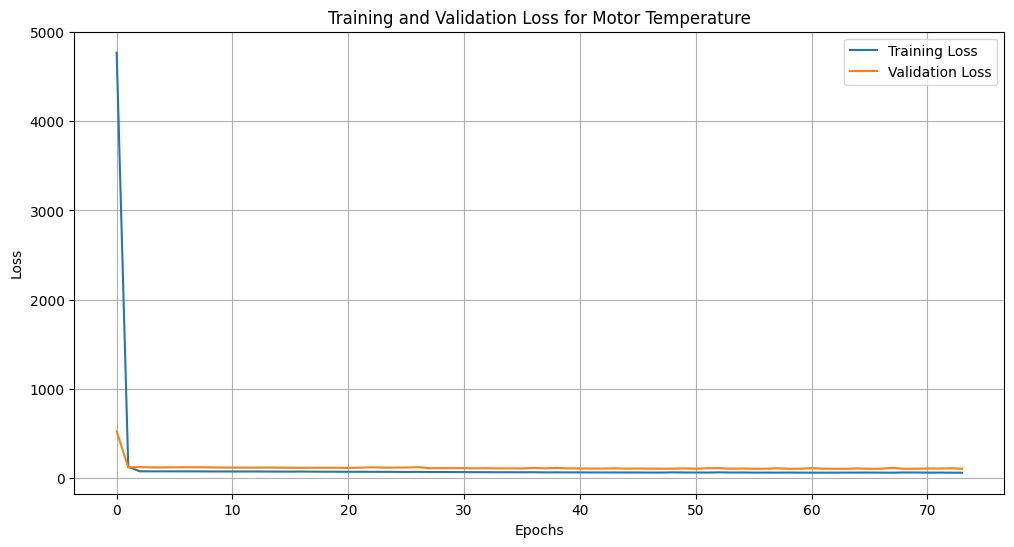

Plotting training history for Belt Load...


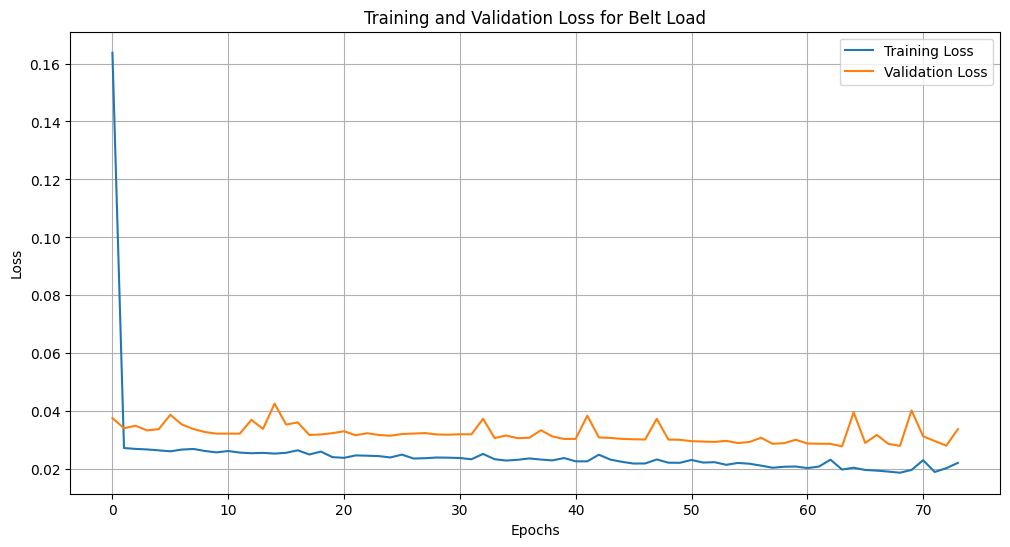

Plotting training history for Torque...


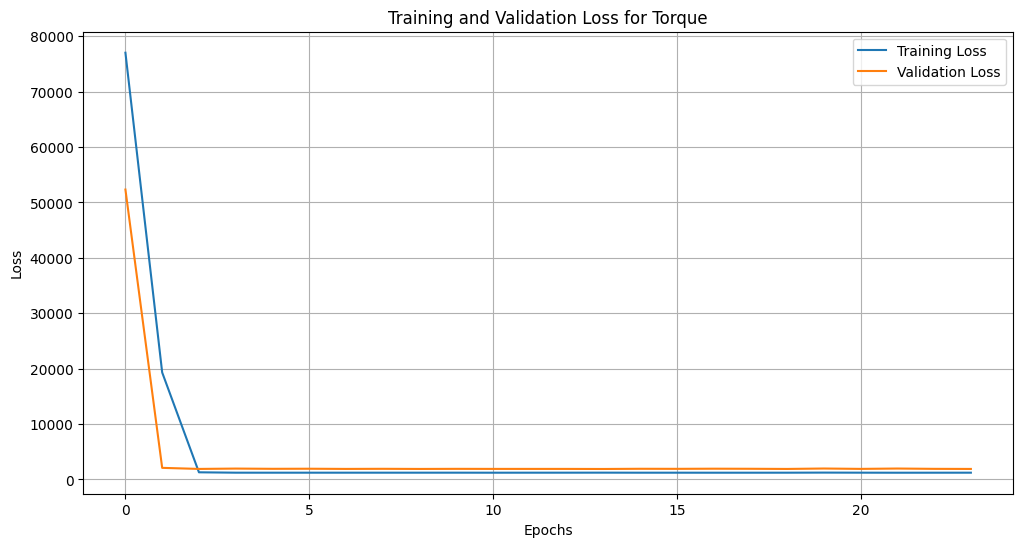

Plotting training history for Noise Levels...


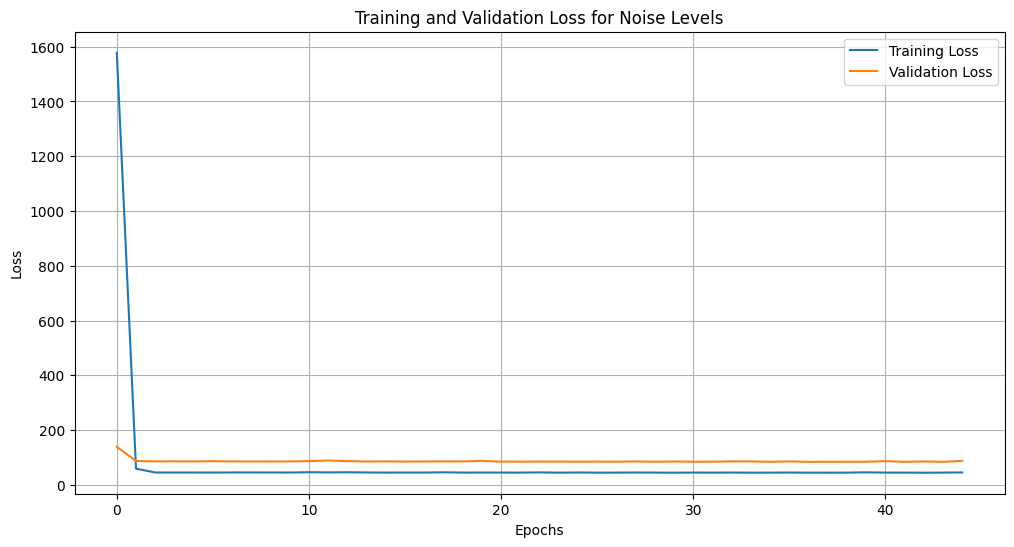

Plotting training history for Current and Voltage...


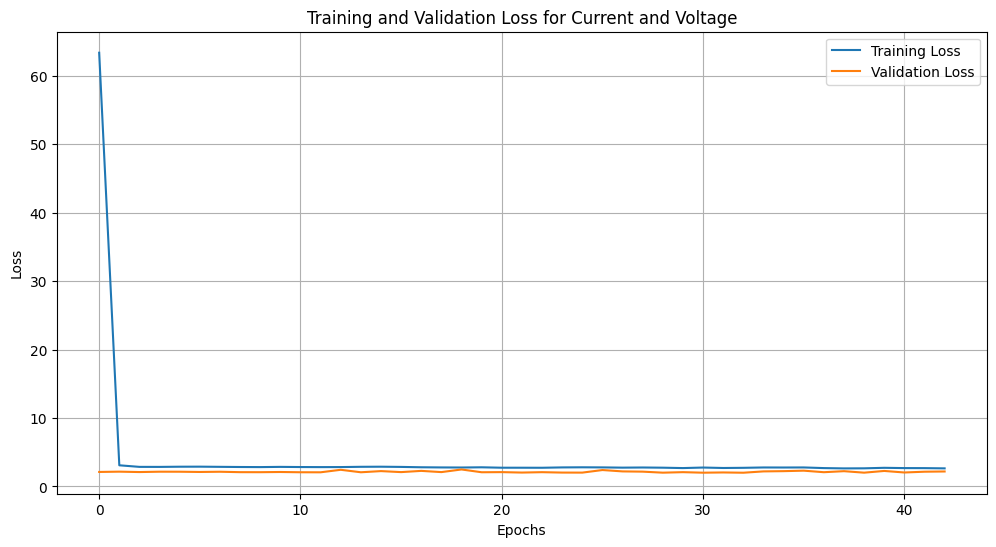

Plotting training history for Hydraulic Pressure...


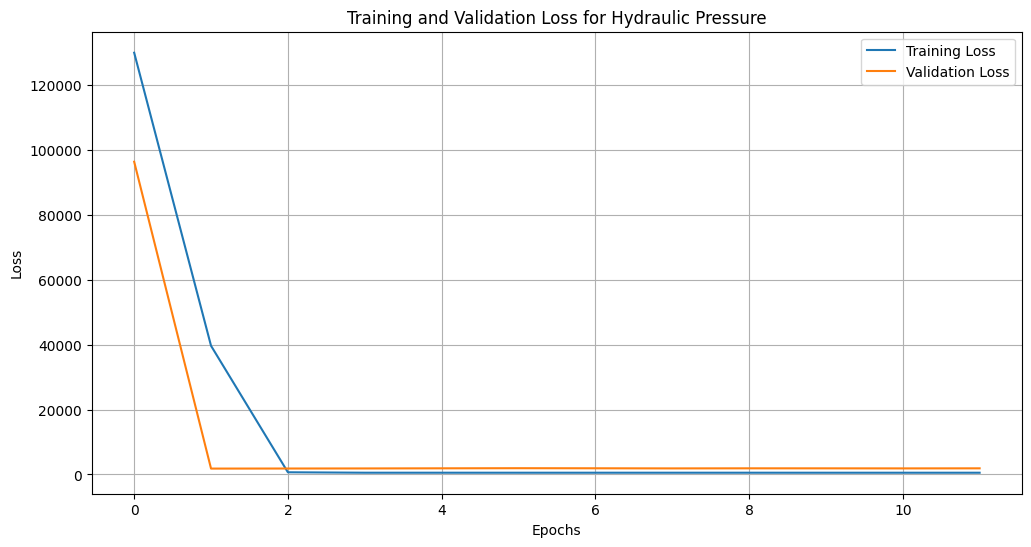

Plotting training history for Belt Thickness...


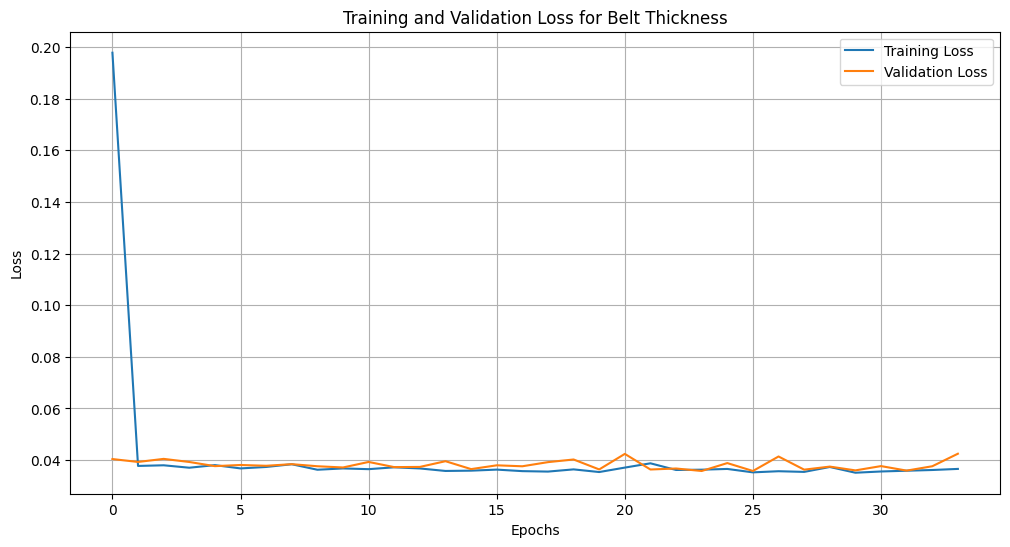

Plotting training history for Roller Condition...


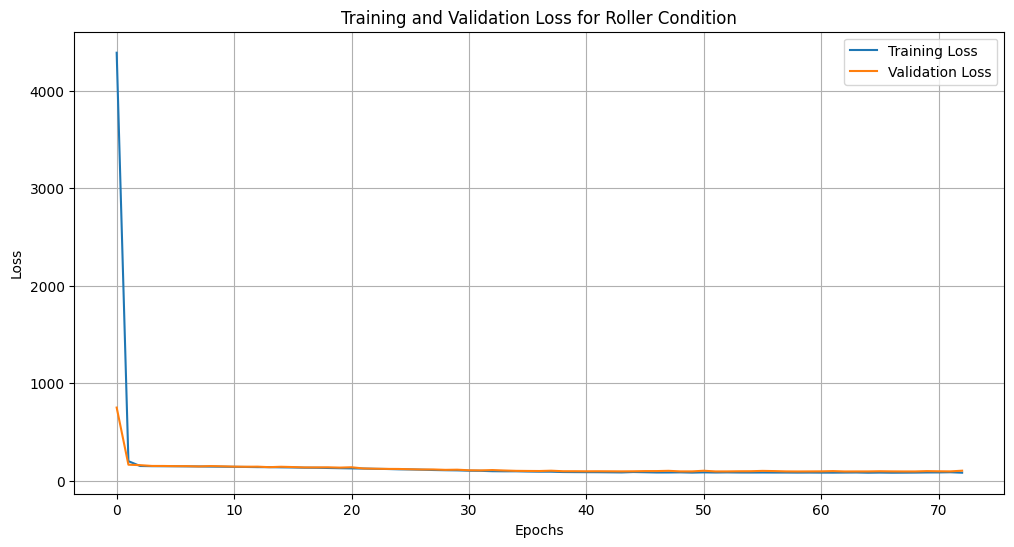

In [54]:
# 5. Plot Training History Function
def plot_training_history(history, target):
    """Plot the training and validation loss over epochs for each model."""
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {target}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

# Call plot_training_history for each model
for target in models.keys():
    print(f"Plotting training history for {target}...")
    plot_training_history(models[target].history, target)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2181517.0000 - val_loss: 1980391.3750
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1777775.0000 - val_loss: 915942.5625
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 621883.8125 - val_loss: 41947.6367
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35705.7031 - val_loss: 28350.3965
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34042.1992 - val_loss: 27822.0195
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33459.2656 - val_loss: 27964.2520
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32191.6035 - val_loss: 27877.0781
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30907.3086 - val_loss: 27948.0586
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31953.6699 - val_loss: 27999.2441
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30713.5430 - val_loss: 27761.5117
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2

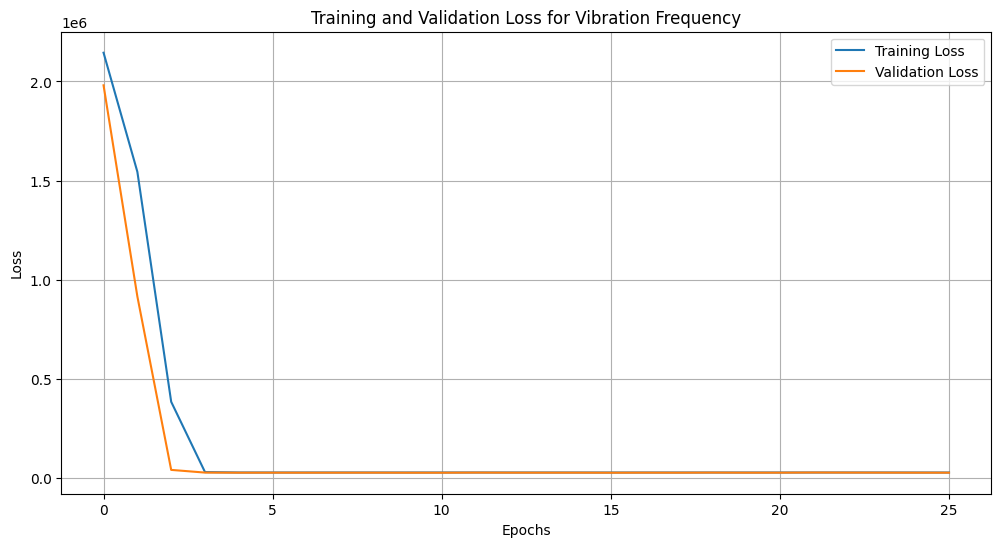

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2363 - val_loss: 0.0083
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 9.9623e-04
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5664e-04 - val_loss: 9.3065e-04
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9428e-04 - val_loss: 7.9079e-04
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3181e-04 - val_loss: 6.5989e-04
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7116e-04 - val_loss: 6.4163e-04
Epoch 12/100
52/52 ━━━━━━━━

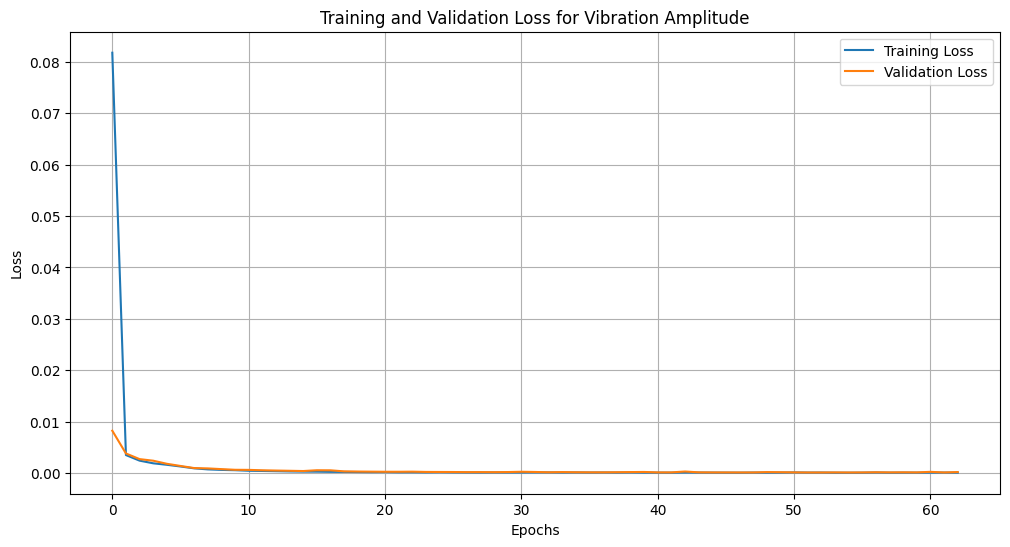

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3668.1917 - val_loss: 68.8274
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111.6850 - val_loss: 25.8936
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.0813 - val_loss: 26.6881
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95.1922 - val_loss: 26.2585
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.6926 - val_loss: 25.4202
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85.1034 - val_loss: 25.1775
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 80.4336 - val_loss: 25.1242
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 79.1314 - val_loss: 25.6009
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97.9853 - val_loss: 24.2307
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102.1894 - val_loss: 23.9686
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94.2135 - val_loss: 23.8596
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━

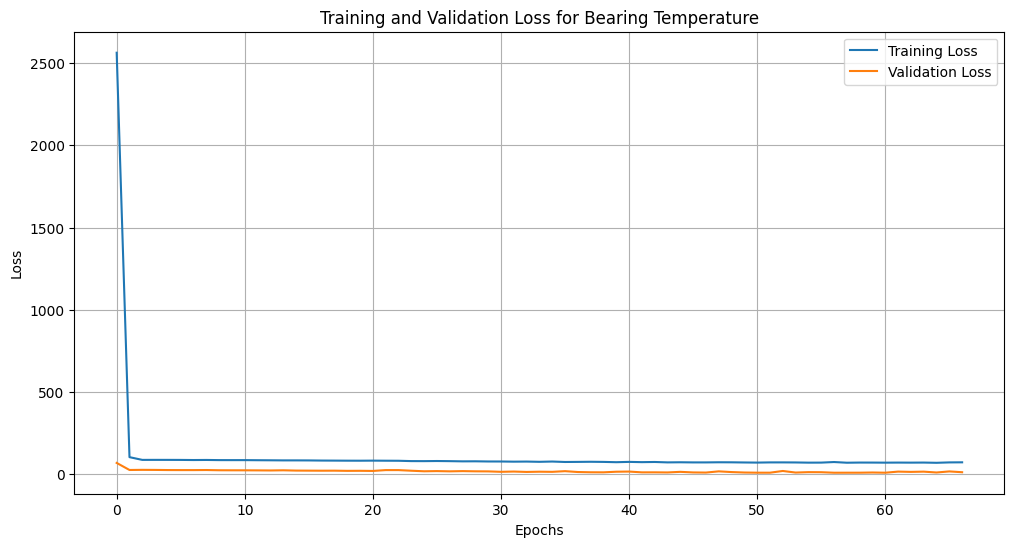

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6870.3716 - val_loss: 1674.2699
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 669.0200 - val_loss: 120.5010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69.9809 - val_loss: 123.3330
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92.1405 - val_loss: 122.4288
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 94.4251 - val_loss: 127.4427
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 91.9080 - val_loss: 125.7787
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 86.3937 - val_loss: 124.3588
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 66.6454 - val_loss: 120.7111
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 97.1427 - val_loss: 123.6787
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 82.3725 - val_loss: 122.9564
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 60.6909 - val_loss: 120.0693
Epoch 12/100
52/52 ━━━━━━━

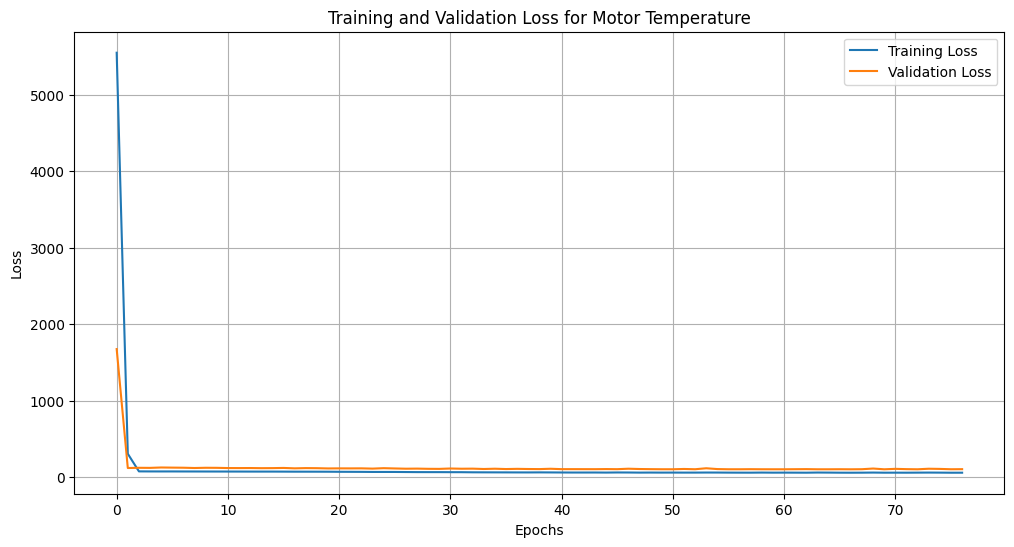

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4032 - val_loss: 0.0364
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - val_loss: 0.0351
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - val_loss: 0.0348
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - val_loss: 0.0343
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0338
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.0345
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.0337
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.0343
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 - val_loss: 0.0368
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 - val_loss: 0.0332
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.0331
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

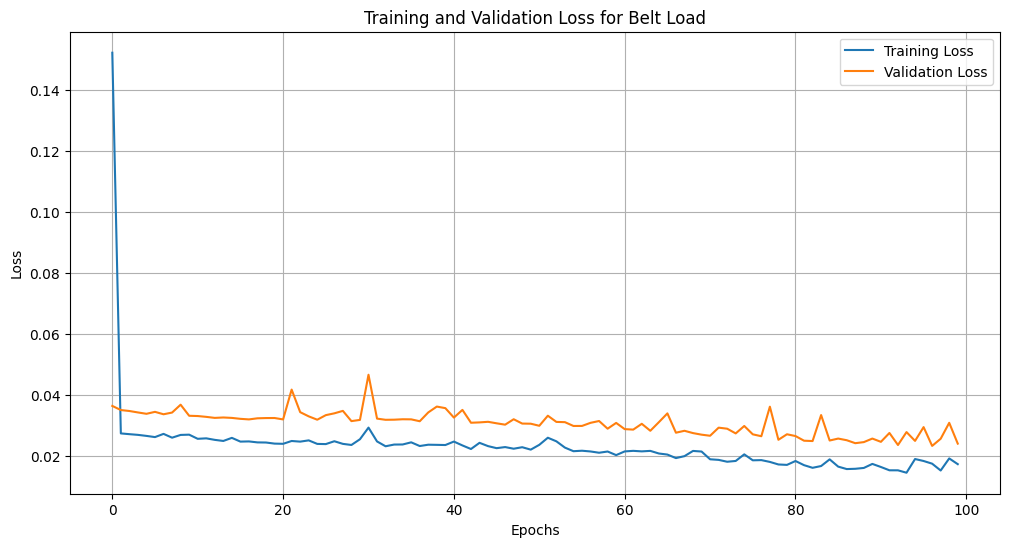

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 84227.6797 - val_loss: 57134.8789
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39709.2539 - val_loss: 1898.6200
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1227.2675 - val_loss: 1910.9434
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1357.2706 - val_loss: 1955.0225
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1272.3018 - val_loss: 1935.8309
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1145.1881 - val_loss: 1943.2810
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1269.3704 - val_loss: 1906.2279
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1394.8143 - val_loss: 1931.0195
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1365.9067 - val_loss: 1926.6940
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1237.6556 - val_loss: 1916.2986
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1326.6725 - val_loss: 1907

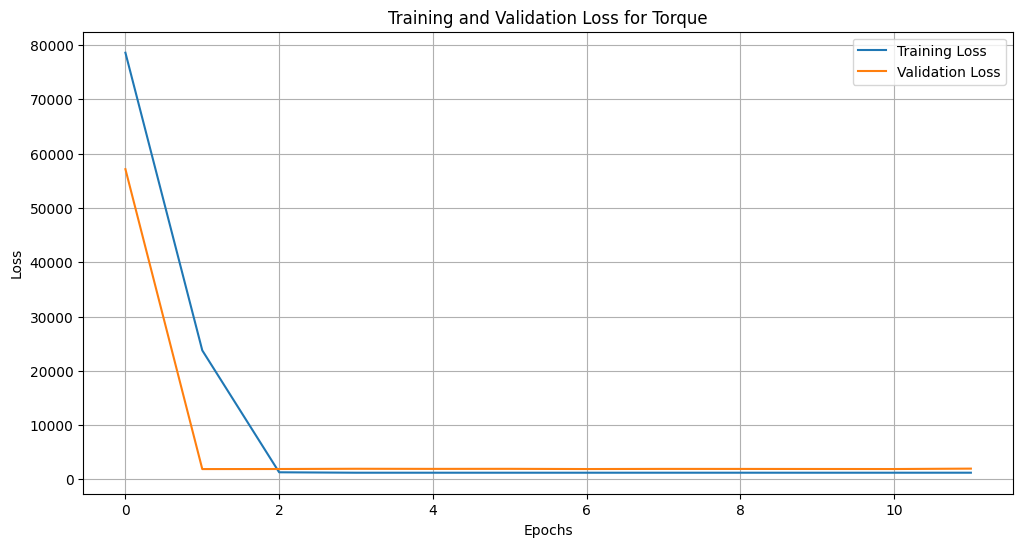

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2844.5291 - val_loss: 86.3309
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.7525 - val_loss: 85.6095
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.1642 - val_loss: 84.9823
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.3866 - val_loss: 84.9243
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.4598 - val_loss: 85.2215
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.6628 - val_loss: 85.0589
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.5844 - val_loss: 85.6978
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.6852 - val_loss: 86.3200
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.0311 - val_loss: 85.0038
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.0694 - val_loss: 84.7464
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.1623 - val_loss: 84.7577
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━

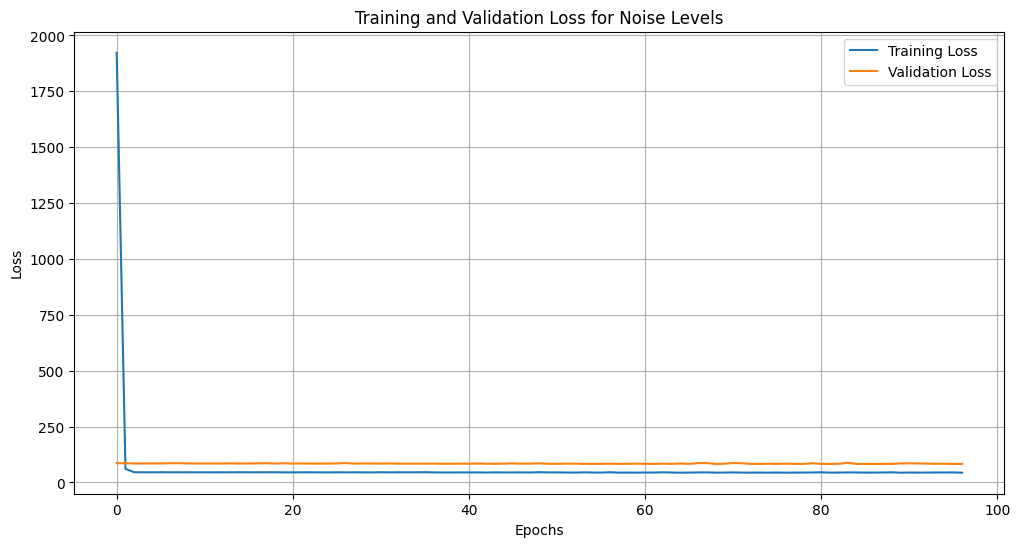

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 109.9656 - val_loss: 2.8020
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9846 - val_loss: 2.2094
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6519 - val_loss: 2.1389
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3618 - val_loss: 2.1126
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1288 - val_loss: 2.0962
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4238 - val_loss: 2.3231
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5009 - val_loss: 2.1966
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7744 - val_loss: 2.1017
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7928 - val_loss: 2.1315
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7220 - val_loss: 2.1195
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7217 - val_loss: 2.1296
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4

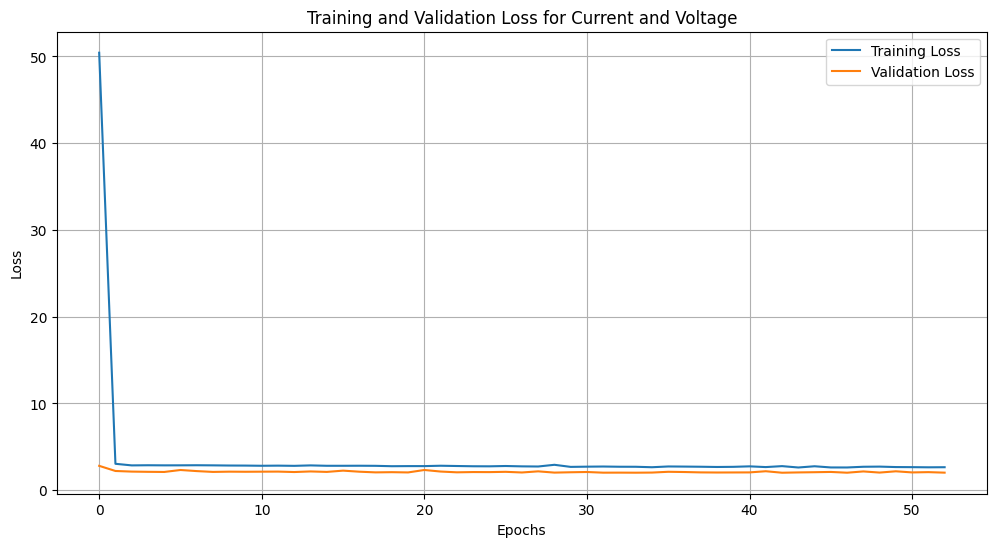

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 136570.0781 - val_loss: 94161.7266
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66548.1641 - val_loss: 1877.1289
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 691.8254 - val_loss: 1827.5447
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 574.5953 - val_loss: 1870.3628
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 416.8344 - val_loss: 1861.1401
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 457.3888 - val_loss: 1896.5100
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 491.9745 - val_loss: 1881.8890
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 235.5249 - val_loss: 1834.0691
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 359.3044 - val_loss: 1853.0764
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 340.8864 - val_loss: 1863.0471
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 723.0226 - val_loss: 1853.3799
Ep

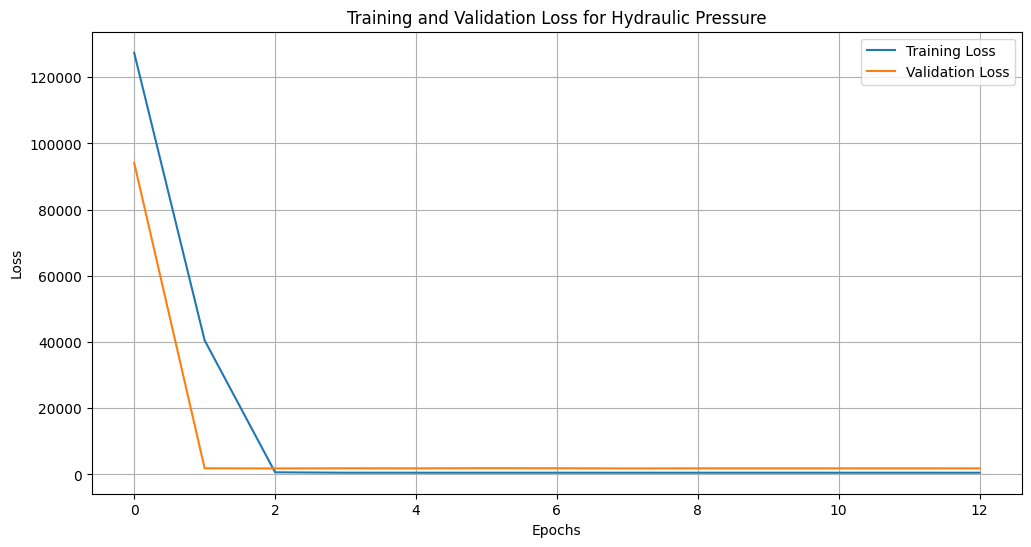

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3937 - val_loss: 0.0364
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0492 - val_loss: 0.0361
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0348 - val_loss: 0.0373
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0420 - val_loss: 0.0385
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310 - val_loss: 0.0358
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0345 - val_loss: 0.0358
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0411 - val_loss: 0.0375
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366 - val_loss: 0.0357
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0358 - val_loss: 0.0385
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0375 - val_loss: 0.0360
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 - val_loss: 0.0356
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

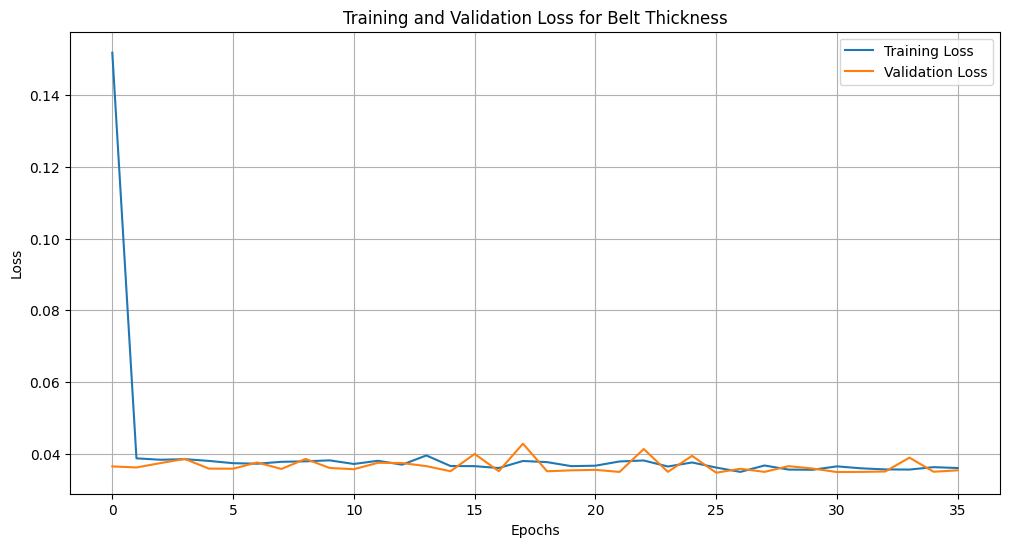

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6181.2485 - val_loss: 1720.3828
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 610.3510 - val_loss: 158.3532
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 163.1272 - val_loss: 153.3291
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 132.1841 - val_loss: 152.2186
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 158.8208 - val_loss: 146.1081
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 157.2182 - val_loss: 149.9079
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 140.8472 - val_loss: 148.4791
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 128.6845 - val_loss: 147.0112
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 147.0493 - val_loss: 147.1116
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 116.1707 - val_loss: 143.4740
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 160.8957 - val_loss: 140.5056
Epoch 12/100
52/5

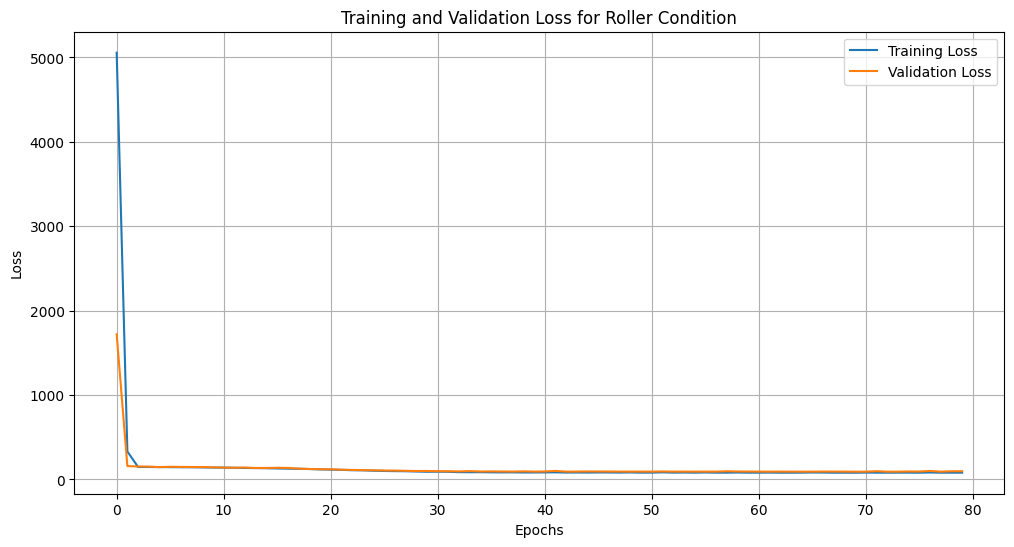

Predicting for 'good' data...
No model found for Vibration Frequency in good. Skipping...
No model found for Vibration Amplitude in good. Skipping...
No model found for Bearing Temperature in good. Skipping...
No model found for Motor Temperature in good. Skipping...
No model found for Belt Load in good. Skipping...
No model found for Torque in good. Skipping...
No model found for Noise Levels in good. Skipping...
No model found for Current and Voltage in good. Skipping...
No model found for Hydraulic Pressure in good. Skipping...
No model found for Belt Thickness in good. Skipping...
No model found for Roller Condition in good. Skipping...


KeyError: "['Vibration Frequency', 'Vibration Amplitude', 'Bearing Temperature', 'Motor Temperature', 'Belt Load', 'Torque', 'Noise Levels', 'Current and Voltage', 'Hydraulic Pressure', 'Belt Thickness', 'Roller Condition'] not in index"

In [ ]:
def predict_last_rows(models, scalers, cleaned_data, target_columns):
    """Predict the last 10 rows and display a table of original and predicted float values for relevant features."""
    cleaned_data = clean_and_preprocess_data(data)


    for sheet_name, sheet_data in cleaned_data.items():
        print(f"Predicting for '{sheet_name}' data...")

        # Check if sheet_data is a DataFrame
        if not isinstance(sheet_data, pd.DataFrame):
            print(f"Expected DataFrame but got: {type(sheet_data)}. Skipping...")
            continue

        # Check if the 'Timestamp' column exists
        if 'Timestamp' not in sheet_data.columns:
            print(f"'Timestamp' column is missing in the sheet: {sheet_name}. Skipping...")
            continue

        # Get the last 10 rows of data
        last_n_rows = sheet_data.tail(10)
        timestamps = last_n_rows['Timestamp']  # Retain timestamps for final output
        results = {target: [] for target in target_columns}  # Initialize a dictionary for results

        for target in target_columns:
            model_key = f"{target}_{sheet_name}"
            if model_key not in models:
                print(f"No model found for {target} in {sheet_name}. Skipping...")
                continue

            model = models[model_key]
            scaler = scalers[model_key]

            # Prepare features: include all columns except the target column
            feature_names = sheet_data.columns.tolist()
            feature_names.remove(target)  # Remove target column from features

            # Prepare features for the last rows
            X_last = last_n_rows[feature_names].copy()
            X_last.fillna(0, inplace=True)  # Fill NaN values

            # Scale the features using the stored scaler
            try:
                X_last_scaled = scaler.transform(X_last[feature_names])
            except ValueError as e:
                print(f"Error during scaling: {e}")
                continue

            # Reshape for prediction based on the model's expected input
            timesteps = 5  # Adjust this according to your model's requirement

            # Check if the array has enough data points to reshape
            if X_last_scaled.shape[0] >= timesteps:
                X_last_scaled = X_last_scaled[-timesteps:].reshape((1, timesteps, X_last_scaled.shape[1]))  # Reshape to (1, timesteps, features)
            else:
                print("Insufficient data to create the required timesteps.")
                continue

            # Make predictions
            predictions = []
            for _ in range(10):  # We want to predict the next 10 rows
                prediction = model.predict(X_last_scaled)
                predictions.append(prediction[0][0])  # Store the first prediction value

                # Prepare the input for the next iteration
                last_row = X_last_scaled[-1, -1, :].copy()  # Take the last row of the input
                last_row = np.append(last_row[:-1], prediction[0][0])  # Update the target column with predicted value

                # Add noise to simulate variability for other features
                for feature in feature_names:
                    noise = np.random.uniform(-0.5, 0.5)  # Adding noise
                    last_row[feature_names.index(feature)] += noise  # Update feature with noise

                # Reshape for the next prediction
                X_last_scaled = np.append(X_last_scaled, [[last_row]], axis=1)  # Append new row and keep the timesteps

            # Store original and predicted values in results
            for i in range(len(predictions)):
                results[target].append({
                    'Timestamp': timestamps.iloc[i],
                    'Original': last_n_rows.iloc[i][target],
                    'Predicted': predictions[i]  # Flatten the prediction if it's an array
                })

        # Create a list to hold all rows for the final DataFrame
        final_rows = []

        # Fill final rows with original and predicted values
        for i in range(10):  # We want 10 original and 10 predicted
            # Original row
            original_row = {'Status': 'Original', 'Timestamp': timestamps.iloc[i]}
            for target in target_columns:
                if i < len(results[target]):
                    original_row[target] = results[target][i]['Original']
            final_rows.append(original_row)

            # Predicted row
            predicted_row = {'Status': 'Predicted', 'Timestamp': timestamps.iloc[i]}
            for target in target_columns:
                if i < len(results[target]):
                    predicted_row[target] = results[target][i]['Predicted']
            final_rows.append(predicted_row)

        # Convert the list of rows into a DataFrame
        final_display = pd.DataFrame(final_rows)

        # Display the relevant columns
        relevant_columns = ['Status', 'Timestamp'] + target_columns
        final_display = final_display[relevant_columns]

        print("Combined original and predicted values for the last 10 rows:")
        display(final_display)

models, scalers = train_models(cleaned_data)  # Ensure this step succeeds without issues

# Call predict_last_rows after making the adjustments
predict_last_rows(models, scalers, cleaned_data, target_columns)


In [ ]:
def predict_last_rows(models, scalers, cleaned_data, target_columns):
    """Predict the last 10 rows and display a table of original and predicted float values for relevant features."""
    for sheet_name, sheet_data in cleaned_data.items():
        print(f"Predicting for '{sheet_name}' data...")

        # Check if the 'Timestamp' column exists
        if 'Timestamp' not in sheet_data.columns:
            print(f"'Timestamp' column is missing in the sheet: {sheet_name}. Skipping...")
            continue

        # Get the last 10 rows of data
        last_n_rows = sheet_data.tail(10)
        timestamps = last_n_rows['Timestamp']  # Retain timestamps for final output
        results = {target: [] for target in target_columns}  # Initialize a dictionary for results

        for target in target_columns:
            model_key = f"{target}_{sheet_name}"
            if model_key not in models:
                print(f"No model found for {target} in {sheet_name}. Skipping...")
                continue

            model = models[model_key]
            scaler = scalers[model_key]

            # Prepare features: include all columns except the target column
            feature_names = sheet_data.columns.tolist()
            feature_names.remove(target)  # Remove target column


In [ ]:
def predict_last_rows(models, scalers, cleaned_data, target_columns):
    """Predict the last 10 rows and display a table of original and predicted float values for relevant features."""
    for sheet_name, sheet_data in cleaned_data.items():
        print(f"Predicting for '{sheet_name}' data...")

        # Get the last 10 rows of data
        last_n_rows = sheet_data.tail(10)
        print("Last 10 rows of data:\n", last_n_rows)

        # Ensure 'Timestamp' exists in last_n_rows
        if 'Timestamp' not in last_n_rows.columns:
            print("Error: 'Timestamp' column not found in the last rows.")
            continue

        timestamps = last_n_rows['Timestamp'].copy()  # Retain timestamps for final output
        results = {target: [] for target in target_columns}  # Initialize a dictionary for results

        for target in target_columns:
            model_key = f"{target}_{sheet_name}"
            if model_key not in models:
                print(f"No model found for {target} in {sheet_name}. Skipping...")
                continue

            model = models[model_key]
            scaler = scalers[model_key]

            # Prepare features: include all columns except the target column
            feature_names = sheet_data.columns.tolist()
            feature_names.remove(target)  # Remove target column from features

            # Prepare features for the last rows
            X_last = last_n_rows[feature_names].copy()
            X_last.fillna(0, inplace=True)  # Fill NaN values

            # Scale the features using the stored scaler
            try:
                X_last_scaled = scaler.transform(X_last[feature_names])
            except ValueError as e:
                print(f"Error during scaling: {e}")
                continue

            # Reshape for prediction based on the model's expected input
            timesteps = 5  # Adjust this according to your model's requirement

            # Ensure we have enough samples to reshape
            if X_last_scaled.shape[0] >= timesteps:
                X_last_scaled = X_last_scaled[-timesteps:].reshape((1, timesteps, X_last_scaled.shape[1]))  # Reshape to (1, timesteps, features)
            else:
                print("Insufficient data to create the required timesteps.")
                continue

            # Make predictions
            predictions = []
            for _ in range(10):  # We want to predict the next 10 rows
                prediction = model.predict(X_last_scaled)
                predictions.append(prediction[0][0])  # Store the first prediction value

                # Prepare the input for the next prediction
                last_row = X_last_scaled[-1, -1, :].copy()  # Take the last row of the input
                last_row = np.append(last_row[:-1], prediction[0][0])  # Update the target column with predicted value

                # Add noise to simulate variability for other features
                for feature in feature_names:
                    noise = np.random.uniform(-0.5, 0.5)
                    last_row[feature_names.index(feature)] += noise

                # Reshape for the next prediction
                X_last_scaled = np.append(X_last_scaled, [[last_row]], axis=1)

            # Store original and predicted values in results
            for i in range(len(predictions)):
                results[target].append({
                    'Timestamp': timestamps.iloc[i],
                    'Original': last_n_rows.iloc[i][target],
                    'Predicted': predictions[i]
                })

        # Create a list to hold all rows for the final DataFrame
        final_rows = []

        # Fill final rows with original and predicted values
        for i in range(10):  # We want 10 original and 10 predicted
            # Original row
            original_row = {'Status': 'Original', 'Timestamp': timestamps.iloc[i]}
            for target in target_columns:
                original_row[target] = results[target][i]['Original']
            final_rows.append(original_row)

            # Predicted row
            predicted_row = {'Status': 'Predicted', 'Timestamp': timestamps.iloc[i]}
            for target in target_columns:
                predicted_row[target] = results[target][i]['Predicted']
            final_rows.append(predicted_row)

        # Convert the list of rows into a DataFrame
        final_display = pd.DataFrame(final_rows)

        # Display the relevant columns
        relevant_columns = ['Status', 'Timestamp'] + target_columns
        final_display = final_display[relevant_columns]

        print("Combined original and predicted values for the last 10 rows:")
        display(final_display)

# Call predict_last_rows after making the adjustments
predict_last_rows(models, scalers, cleaned_data, target_columns)


Predicting for 'Name' data...
Last 10 rows of data:
 2605    0.0
2606    0.0
2607    0.0
2608    0.0
2609    0.0
2610    0.0
2611    0.0
2612    0.0
2613    0.0
2614    0.0
Name: Name, dtype: float64


AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
bb

In [ ]:
def predict_next_rows(models, scalers, cleaned_data, target_column):
    """Predict the next 10 rows for the specified target column and add maintenance status and description."""
    for sheet_name, sheet_data in cleaned_data.items():
        # Ensure we are only processing bad data
        if sheet_name != 'bad':
            continue

        print(f"Predicting for '{sheet_name}' data...")

        # Get the last row of bad data to start predicting from
        last_row = sheet_data.tail(1).copy()
        timestamps = pd.date_range(start=last_row['Timestamp'].iloc[0], periods=11, freq='15T')[1:]  # Create next 10 timestamps
        maintenance_status = []
        descriptions = []
        predicted_values = []

        # Prepare features for the model
        feature_names = sheet_data.columns.tolist()
        feature_names.remove(target_column)  # Remove target column from features
        for _ in range(10):  # Predict the next 10 rows
            model_key = f"{target_column}_{sheet_name}"
            if model_key not in models:
                print(f"No model found for {target_column} in {sheet_name}. Skipping...")
                return

            model = models[model_key]
            scaler = scalers[model_key]

            # Prepare features for the model
            X_last = last_row[feature_names].copy()
            X_last.fillna(0, inplace=True)  # Fill NaN values

            # Scale the features using the stored scaler
            X_last_scaled = scaler.transform(X_last[feature_names])

            # Make prediction
            prediction = model.predict(X_last_scaled)

            # Store the predicted value
            predicted_value = prediction[0]
            predicted_values.append(predicted_value)

            # Determine maintenance status and description
            if not (1490 <= predicted_value <= 1510):
                maintenance_status.append('Maintenance')
                descriptions.append('Vibration frequency is out of expected range (1490-1510 Hz).')
            else:
                maintenance_status.append('Normal')
                descriptions.append('Vibration frequency is within expected range.')

            # Update the last_row for the next iteration
            last_row[target_column] = predicted_value  # Update the target column with the predicted value

            # Introduce small variability to the other features for the next iteration
            for feature in feature_names:
                noise = np.random.uniform(-0.5, 0.5)  # Adding some small noise
                last_row[feature] += noise  # Update feature with noise to simulate changes

        # Create a DataFrame for predictions
        results = pd.DataFrame({
            'Timestamp': timestamps,
            'Vibration Frequency': predicted_values,
            'Maintenance Status': maintenance_status,
            'Description': descriptions
        })

        print("Predicted values for the next 10 rows:")
        display(results)

# Call predict_next_rows for the 'Vibration Frequency'
predict_next_rows(models, scalers, cleaned_data, 'Vibration Frequency')


Predicting for 'bad' data...


<ipython-input-9-fd925b59f786>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start=last_row['Timestamp'].iloc[0], periods=11, freq='15T')[1:]  # Create next 10 timestamps
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


ValueError: as_list() is not defined on an unknown TensorShape.